In [1]:
#%env SM_FRAMEWORK=tf.keras

In [1]:
import os
import numpy as np
import imageio
from matplotlib import pyplot as plt

import segmentation_models as sm
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

import tensorflow as tf
import keras
import cv2

from tensorflow.keras.layers import Input, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import albumentations as A

Segmentation Models: using `keras` framework.


In [3]:
path = ""

acdc_path = "acdc_data"
sunnybrook_path = "sunnybrook_data"

images_path = "result_images"
labels_path = "result_labels"

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# classes for data loading and preprocessing
class Dataset:

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None
    ):
        all_ids = os.listdir(images_dir)
        self.ids = [x for x in all_ids if x!='.ipynb_checkpoints']
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=2)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=2)
        
        image = image/255.
        mask = mask/255.
        
        image = np.array(image, dtype = np.float32)
        mask = np.array(mask, dtype = np.float32)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']    
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = tuple([np.stack(samples, axis=0) for samples in zip(*data)])
        #batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [5]:
# define heavy augmentations
def get_augmentation():
    transform = [
    A.RandomSizedCrop([150,200], 256, 256),
    A.HorizontalFlip(p=0.9),
    A.Rotate(border_mode=0,  p=1),
    A.RandomBrightnessContrast(p=0.7),
    A.Blur([3,5],p=0.5)
    ]
    return A.Compose(transform)


In [6]:
x_train_dir = "train_data/images"
y_train_dir = "train_data/labels"

x_valid_dir = "validation_data/images"
y_valid_dir = "validation_data/labels"

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    augmentation=get_augmentation()
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir
)

BATCH_SIZE = 4

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=True)


In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


new_path = "models_result/vgg16_100epochs_batch4"
name = os.path.join(new_path, "modelUnet_ring_dropout_vgg16_best.h5")


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    ReduceLROnPlateau(),
    GarbageCollectorCallback(),
    #EarlyStopping(monitor="val_loss", min_delta=0.02, patience=5),
    ModelCheckpoint(name, save_weights_only=True, save_best_only=True,monitor='val_loss', mode='min')
]

In [14]:
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

In [15]:
bb = "vgg16"
input_shape = (256,256,3)
c = 1
enc_weights = "imagenet"
base_model = sm.Unet(backbone_name = bb, input_shape = input_shape, classes = c, activation='sigmoid', encoder_weights = enc_weights)

# define number of channels
N = 1
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
drop = Dropout(0.1)(l1)
bm = base_model(drop)
out = Dropout(0.05)(bm)


lr = 0.0001
optim = Adam(lr)

w = np.array([1,1])
loss = DiceLoss(class_weights=w)
metrics = IOUScore(class_weights=w)

modelUnet = Model(inp, out, name=base_model.name)

modelUnet.compile(optim, loss=loss, metrics=[metrics])

In [ ]:
ep = 100

# train model
history = modelUnet.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=ep, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

new_path = ""#"risultati_train_ring_colab"
name = os.path.join(new_path, "modelUnet_ring_dropout_vgg16_"+str(ep)+"epochs.keras")
#name = os.path.join(new_path, "modelUnet_ring_augmentation_plateau_"+str(ep)+"epochs.keras")
modelUnet.save(name)

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
#plt.show()
name = os.path.join(new_path, "loss_"+ str(ep)+"_epochs.png") 
plt.savefig(name)

In [ ]:
y_pred = modelUnet.predict(valid_dataloader)

In [ ]:
y_pred.shape

(200, 256, 256, 1)

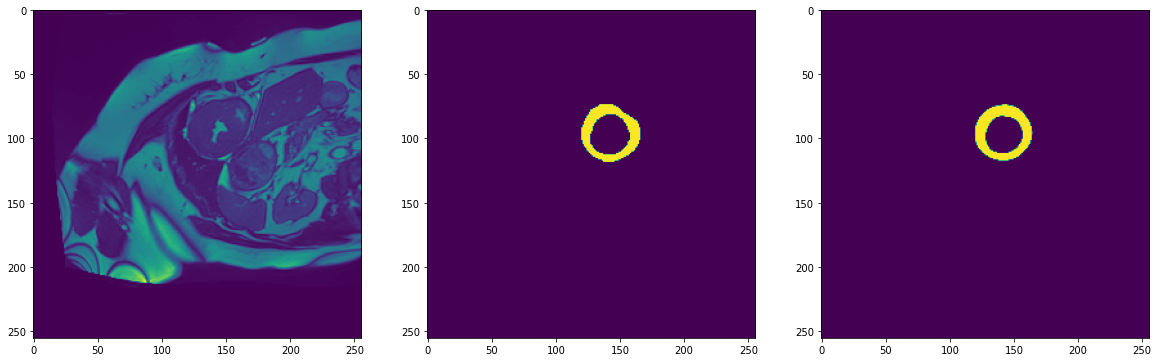

In [ ]:
n = 2
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(x_val[n][:,:,0])
plt.subplot(1,3,2)
plt.imshow(y_val[n][:,:,0])
plt.subplot(1,3,3)
plt.imshow(y_pred[n,:,:,0])

In [ ]:
y_pred = modelUnet.predict(train_dataloader[0][0])

In [ ]:
train_dataloader[0][0].shape

(16, 256, 256, 1)

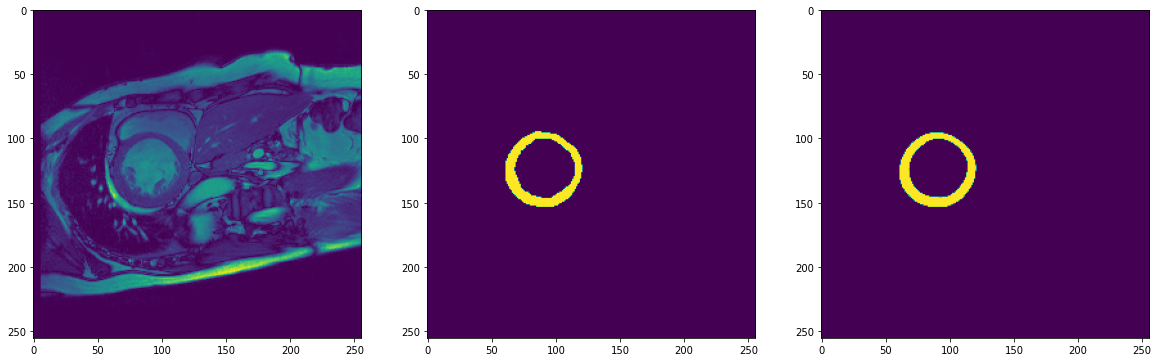

In [ ]:
n = 5
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(train_dataloader[0][0][n,:,:,0])
plt.subplot(1,3,2)
plt.imshow(train_dataloader[0][1][n,:,:,0])
plt.subplot(1,3,3)
plt.imshow(y_pred[n,:,:,0])